In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [81]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [83]:
#Loading the dataset
data = pd.read_excel("marketing.csv.xlsx")
print("Số lượng điểm dữ liệu:", len(data))
data.head()

Số lượng điểm dữ liệu: 2240


,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntFrozenCommodity,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,0,5524,1957,Graduation,Single,58138.0,0,0,2017-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,1,2174,1954,Graduation,Single,46344.0,1,1,2019-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,2,4141,1965,Graduation,Together,71613.0,0,0,2018-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,3,6182,1984,Graduation,Together,26646.0,1,0,2019-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,4,5324,1981,PhD,Married,58293.0,1,0,2019-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [84]:
del data["Unnamed: 0"]
data.shape

(2240, 29)

In [85]:
#Tìm số lượng giá trị duy nhất có trong mỗi cột
data.nunique()

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1973
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntFrozenCommodity      213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

Trong ô ở trên, "Z_CostContact" và "Z_Revenue" có cùng giá trị trong tất cả các hàng, đó là lý do tại sao chúng sẽ không đóng góp gì trong việc xây dựng mô hình. Vì vậy, có thể xóa 2 features này.

In [86]:
data=data.drop(columns=["Z_CostContact", "Z_Revenue"],axis=1)
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntFrozenCommodity,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2017-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,2019-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2018-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2019-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2019-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


In [87]:
# Kiểm tra xem có bất kì điểm dữ liệu nào bị NAN hay không
data.isna().any()

ID                     False
Year_Birth             False
Education              False
Marital_Status         False
Income                  True
Kidhome                False
Teenhome               False
Dt_Customer            False
Recency                False
MntWines               False
MntFruits              False
MntMeatProducts        False
MntFishProducts        False
MntSweetProducts       False
MntFrozenCommodity     False
NumDealsPurchases      False
NumWebPurchases        False
NumCatalogPurchases    False
NumStorePurchases      False
NumWebVisitsMonth      False
AcceptedCmp3           False
AcceptedCmp4           False
AcceptedCmp5           False
AcceptedCmp1           False
AcceptedCmp2           False
Complain               False
Response               False
dtype: bool

Ở cột Icome có dữ liệu NAN. Cần loại bỏ tất cả điểm dữ liệu NAN.

In [88]:
# Để loại bỏ các giá trị NA
data = data.dropna()
print("Tổng số điểm dữ liệu sau khi loại bỏ các hàng có giá trị bị thiếu là:", len(data))

Tổng số điểm dữ liệu sau khi loại bỏ các hàng có giá trị bị thiếu là: 2216


Trong bước tiếp theo, tạo một tính năng từ **"Dt_Customer"** cho biết số ngày khách hàng được đăng ký trong cơ sở dữ liệu của công ty. 

Để có được các giá trị, cần kiểm tra các ngày được ghi mới nhất và cũ nhất.

In [89]:
# Để vẽ một số tính năng đã chọn
# Thiết lập tùy chọn màu sắc
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

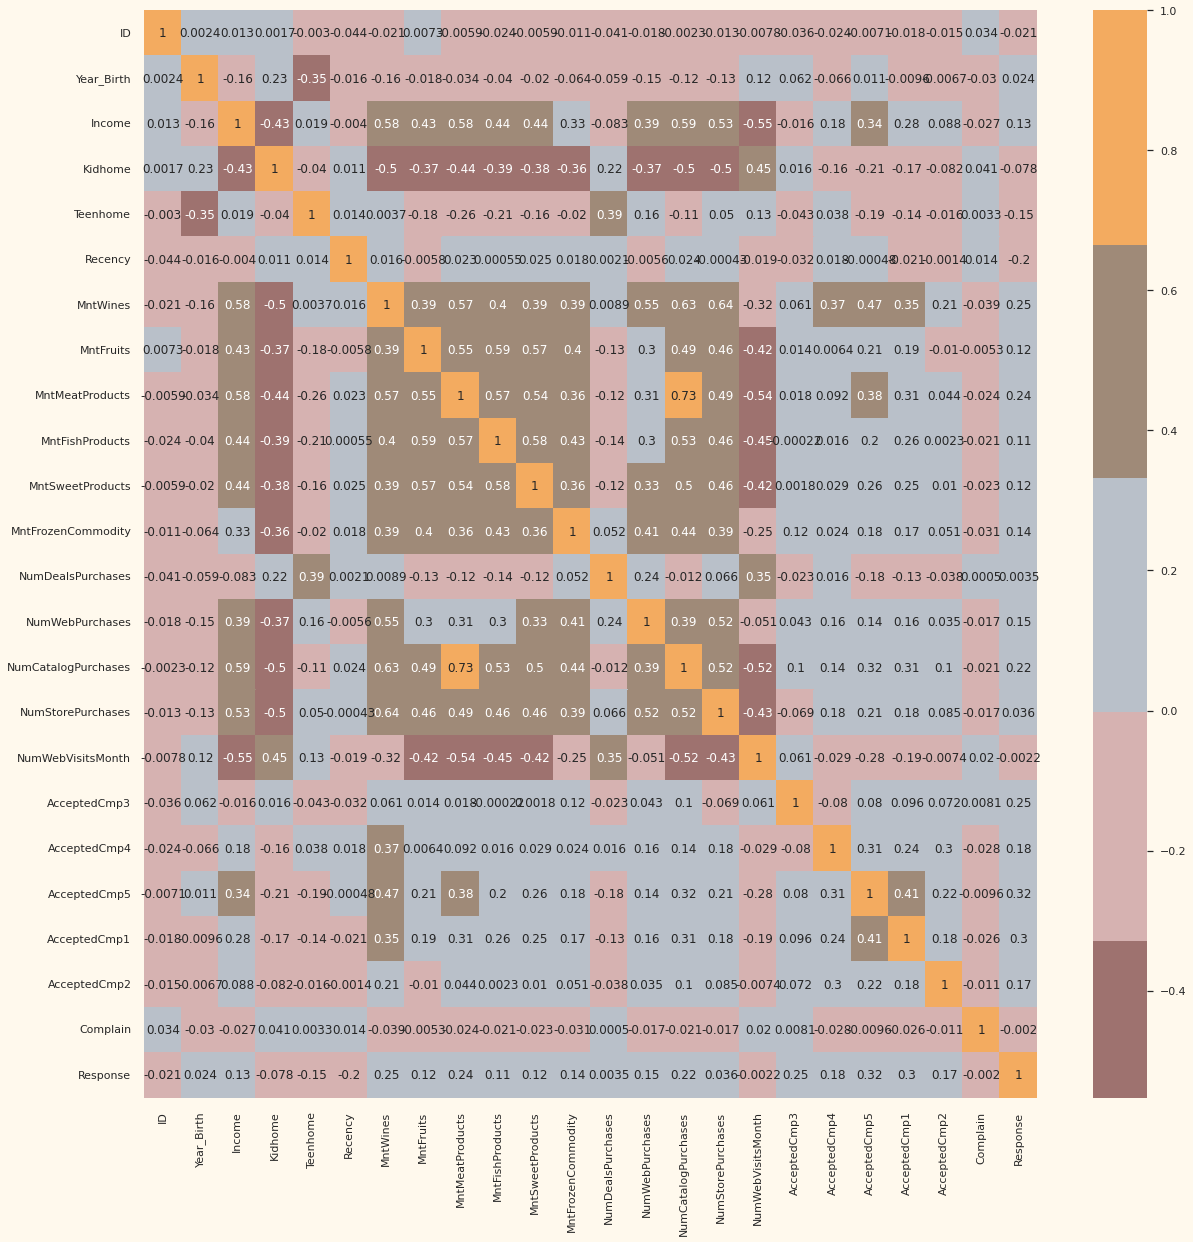

In [90]:
# ma trận tương quan
corrmat= data.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [92]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("Ngày đăng ký của khách hàng mới nhất trong hồ sơ:",max(dates))
print("Ngày đăng ký của khách hàng lâu đời nhất trong hồ sơ:",min(dates))


Ngày đăng ký của khách hàng mới nhất trong hồ sơ: 2019-06-29
Ngày đăng ký của khách hàng lâu đời nhất trong hồ sơ: 2017-07-30


In [93]:
# Tạo một feature "Customer_For"
days = []
d1 = max(dates)  # chọn nó trở thành khách hàng mới nhất
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [94]:
data["Customer_For"]

0       57283200000000000
1        9763200000000000
2       26956800000000000
3       12009600000000000
4       13910400000000000
              ...        
2235    32918400000000000
2236     1641600000000000
2237    13392000000000000
2238    13478400000000000
2239    53740800000000000
Name: Customer_For, Length: 2216, dtype: int64

In [95]:
#Kiểm tra số lượng danh mục duy nhất hiện có.
print("Tổng số danh mục trong feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Tổng số danh mục trong feature Education:\n", data["Education"].value_counts())

Tổng số danh mục trong feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64 

Tổng số danh mục trong feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [96]:
# Thiết kế features
# Tuổi tác hiện tại của khách hàng  
data["Age"] = 2021-data["Year_Birth"]

# Tổng chi tiêu cho các mặt hàng khác nhau
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+data["MntFishProducts"]+data["MntSweetProducts"]+ data["MntFrozenCommodity"]

# Xuất phát hoàn cảnh sống theo tình trạng hôn nhân 
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", 
                                                    "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", 
                                                    "Divorced":"Alone", "Single":"Alone",})

# Tính năng cho biết tổng số trẻ em sống trong hộ gia đình
data["Children"]=data["Kidhome"]+data["Teenhome"]

# Tính năng cho tổng số thành viên trong gia đình
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

# Tính năng liên quan đến tình phụ tử (parenthood)
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

# Phân chia trình độ học vấn theo ba nhóm
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Graduate", 
                                             "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})



# For clarity (Cho rõ ràng)
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat",
                          "MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntFrozenCommodity":"FrozenCommodity"})

# Tổng số lần mua
data['TotalPurchases'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases'] + data['NumDealsPurchases']

# Bỏ một số tính năng thừa
to_drop = ["Marital_Status", "Dt_Customer", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [97]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,FrozenCommodity,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent,TotalPurchases
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.303249,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,3.054423e+16,52.179603,607.075361,0.947202,2.592509,0.714350,14.880866
std,25173.019939,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825,7.670957
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.555200e+16,44.000000,69.000000,0.000000,2.000000,0.000000,8.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.071520e+16,51.000000,396.500000,1.000000,3.000000,1.000000,15.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.570560e+16,62.000000,1048.000000,1.000000,3.000000,1.000000,21.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.039360e+16,128.000000,2525.000000,3.000000,5.000000,1.000000,44.000000


In [98]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,FrozenCommodity,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,TotalPurchases
0,Graduate,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57283200000000000,64,1617,Alone,0,1,0,25
1,Graduate,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,9763200000000000,67,27,Alone,2,3,1,6
2,Graduate,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,26956800000000000,56,776,Partner,0,2,0,21
3,Graduate,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,12009600000000000,37,53,Partner,1,3,1,8
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,13910400000000000,40,422,Partner,1,3,1,19


In [99]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [100]:
trace0 = go.Box(y=data['Income'],name='Income')
trace1 = go.Box(y=data['Age'],name='Age')
trace2 = go.Box(y=data['Recency'],name='Recency')
trace3 = go.Box(y=data['Spent'],name='Spent')
trace4 = go.Box(y=data['TotalPurchases'],name='TotalPurchases')
fig = make_subplots(rows=2, cols=3)
fig.append_trace(trace0, row = 1, col = 1)
fig.append_trace(trace1, row = 1, col = 2)
fig.append_trace(trace2, row = 1, col = 3)
fig.append_trace(trace3, row = 2, col = 1)
fig.append_trace(trace4, row = 2, col = 2)
fig.update_layout(width=800, height=400, title='Box Plot to check for outliers')

fig.show()

In [101]:
# Loại bỏ các yếu tố ngoại lai bằng cách đặt giới hạn về tuổi,thu nhập, tổng số lần mua.
data = data[(data["Age"]<80)]
data = data[(data["Income"]<160000)]
data = data[(data["TotalPurchases"]<40)]
print("Tổng số điểm dữ liệu sau khi loại bỏ các ngoại lệ là:", len(data))

Tổng số điểm dữ liệu sau khi loại bỏ các ngoại lệ là: 2207


In [102]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,FrozenCommodity,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,TotalPurchases
0,Graduate,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57283200000000000,64,1617,Alone,0,1,0,25
1,Graduate,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,9763200000000000,67,27,Alone,2,3,1,6
2,Graduate,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,26956800000000000,56,776,Partner,0,2,0,21
3,Graduate,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,12009600000000000,37,53,Partner,1,3,1,8
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,13910400000000000,40,422,Partner,1,3,1,19


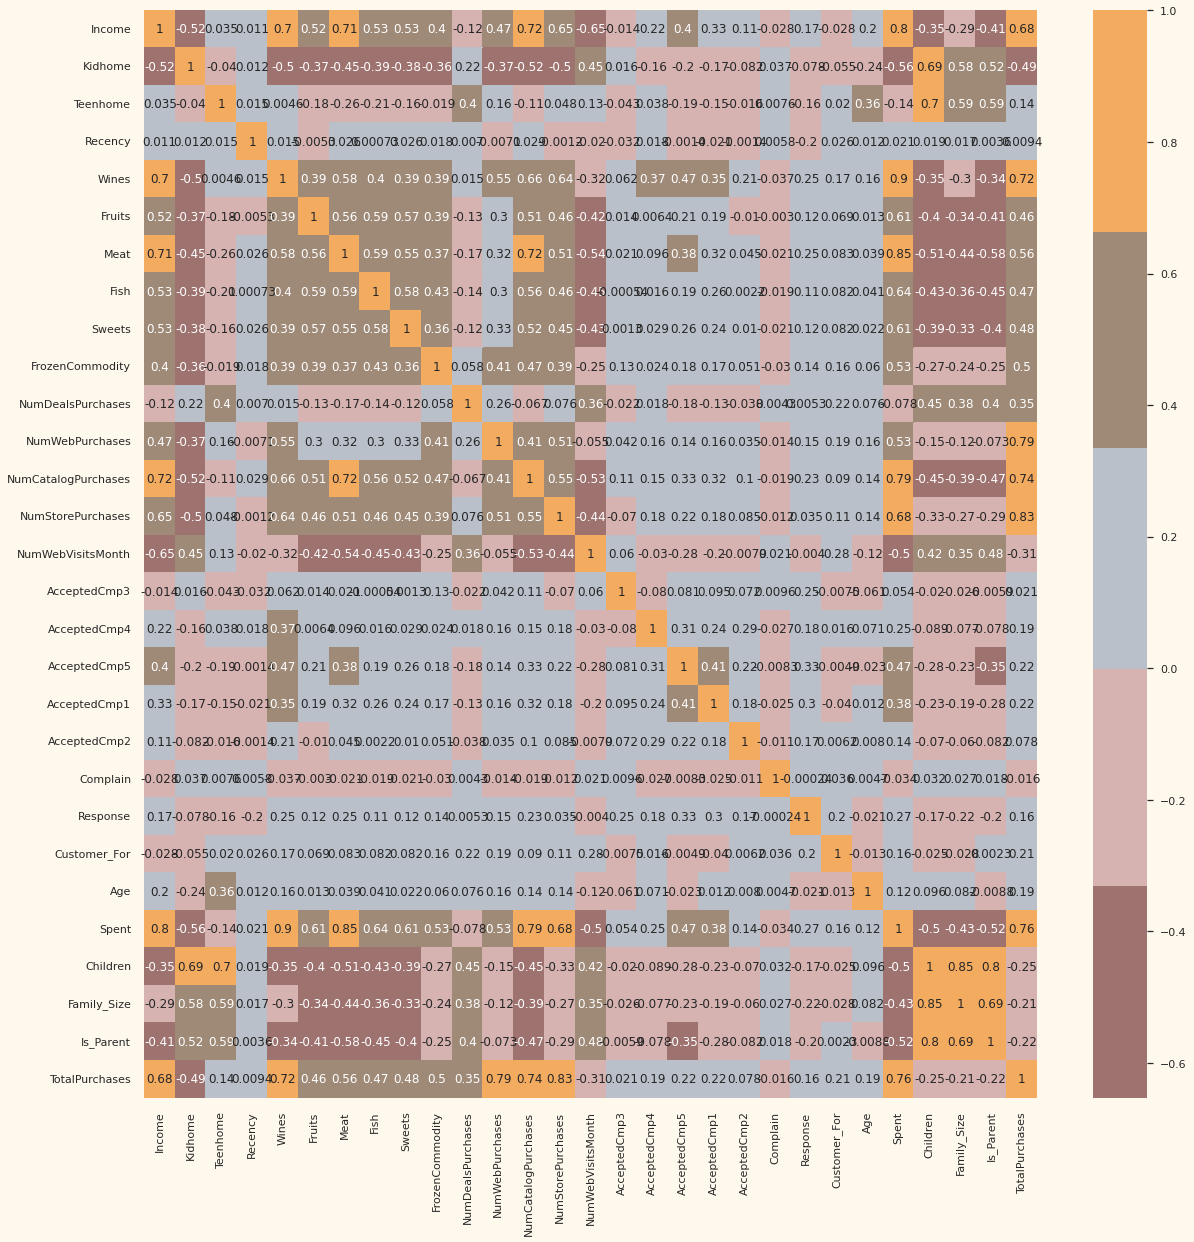

In [103]:
# ma trận tương quan
corrmat= data.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [104]:
# Nhận danh sách các biến phân loại
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Các biến phân loại trong tập bộ liệu:", object_cols)

Các biến phân loại trong tập bộ liệu: ['Education', 'Living_With']


In [105]:
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

In [106]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,FrozenCommodity,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,TotalPurchases
0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57283200000000000,64,1617,0,0,1,0,25
1,0,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,9763200000000000,67,27,0,2,3,1,6
2,0,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,26956800000000000,56,776,1,0,2,0,21
3,0,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,12009600000000000,37,53,1,1,3,1,8
4,1,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,13910400000000000,40,422,1,1,3,1,19


In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [108]:
# Tạo bản sao dữ liệu
ds = data.copy()

# Scaling
scaler = StandardScaler().fit_transform(ds.values)

scaled_ds = pd.DataFrame(scaler, index= ds.index,columns= ds.columns )
print("Tất cả các tính năng hiện đã được scale")

Tất cả các tính năng hiện đã được scale


In [109]:
# Xóa một số cột không cần thiết để giảm kích thước và độ phức tạp của mô hình.

col_del = ["AcceptedCmp1" , "AcceptedCmp2", "AcceptedCmp3" , "AcceptedCmp4","AcceptedCmp5",
           "Response","NumWebVisitsMonth", "NumWebPurchases","NumCatalogPurchases","NumStorePurchases",
           "NumDealsPurchases" , "Kidhome", "Teenhome"]
ds=ds.drop(columns=col_del,axis=1)
ds.head()

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,FrozenCommodity,Complain,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,TotalPurchases
0,0,58138.0,58,635,88,546,172,88,88,0,57283200000000000,64,1617,0,0,1,0,25
1,0,46344.0,38,11,1,6,2,1,6,0,9763200000000000,67,27,0,2,3,1,6
2,0,71613.0,26,426,49,127,111,21,42,0,26956800000000000,56,776,1,0,2,0,21
3,0,26646.0,26,11,4,20,10,3,5,0,12009600000000000,37,53,1,1,3,1,8
4,1,58293.0,94,173,43,118,46,27,15,0,13910400000000000,40,422,1,1,3,1,19


In [110]:
# Dữ liệu được scale sẽ được sử dụng để giảm kích thước
print("Khung dữ liệu sẽ được sử dụng cho further modelling")
scaled_ds.head()

Khung dữ liệu sẽ được sử dụng cho further modelling


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,FrozenCommodity,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,TotalPurchases
0,-0.792984,0.295287,-0.822779,-0.930822,0.310693,0.978930,1.549987,1.733562,2.450642,1.481276,0.850502,0.362665,1.426097,2.603371,-0.558702,0.690156,-0.282393,-0.283327,-0.279577,-0.262231,-0.11739,-0.095629,2.372262,1.528799,1.021504,1.681942,-1.348572,-1.266159,-1.759464,-1.583902,1.328905
1,-0.792984,-0.259774,1.039655,0.906677,-0.380467,-0.873641,-0.637769,-0.727052,-0.651437,-0.635026,-0.734884,-0.167402,-1.128904,-0.583536,-1.174459,-0.136084,-0.282393,-0.283327,-0.279577,-0.262231,-0.11739,-0.095629,-0.421539,-1.187251,1.278472,-0.963254,-1.348572,1.404087,0.448746,0.631352,-1.163937
2,-0.792984,0.929461,-0.822779,-0.930822,-0.795163,0.358437,0.569268,-0.175692,1.337543,-0.148520,-0.038861,-0.697470,1.426097,-0.229436,1.288571,-0.549205,-0.282393,-0.283327,-0.279577,-0.262231,-0.11739,-0.095629,-0.421539,-0.204534,0.336258,0.282816,0.741525,-1.266159,-0.655359,-1.583902,0.804097
3,-0.792984,-1.186821,1.039655,-0.930822,-0.795163,-0.873641,-0.562329,-0.663258,-0.505457,-0.586376,-0.754218,-0.167402,-0.763904,-0.937637,-0.558702,0.277036,-0.282393,-0.283327,-0.279577,-0.262231,-0.11739,-0.095629,-0.421539,-1.058856,-1.291202,-0.920000,0.741525,0.068964,0.448746,0.631352,-0.901532
4,1.051185,0.302582,1.039655,-0.930822,1.554781,-0.392685,0.418389,-0.216702,0.151454,-0.002568,-0.560878,1.422801,0.331097,0.124665,0.057056,-0.136084,-0.282393,-0.283327,-0.279577,-0.262231,-0.11739,-0.095629,-0.421539,-0.950214,-1.034234,-0.306115,0.741525,0.068964,0.448746,0.631352,0.541692


In [111]:
scaled_ds = scaled_ds.drop(columns = ['Wines'])
scaled_ds = scaled_ds.drop(columns = ['Meat'])
scaled_ds = scaled_ds.drop(columns = ['Living_With'])

In [112]:
scaled_ds.describe()

,Education,Income,Kidhome,Teenhome,Recency,Fruits,Fish,Sweets,FrozenCommodity,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent,TotalPurchases
count,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03,2.207000e+03
mean,9.940193e-17,7.037302e-17,-9.658488e-17,-4.077693e-16,-1.144682e-16,-8.038679e-17,-2.469957e-17,-2.283830e-17,-5.598905e-17,-2.945336e-17,2.320804e-16,-3.953943e-17,-7.208652e-17,2.918674e-16,2.042368e-16,5.488234e-17,-3.061036e-16,3.315578e-16,5.332416e-16,-4.561120e-16,-4.408697e-16,4.054553e-17,2.709407e-16,-1.232463e-17,2.017215e-16,-1.920630e-16,-5.117992e-16,-9.256051e-17
std,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00
min,-7.929845e-01,-2.359443e+00,-8.227792e-01,-9.308216e-01,-1.693670e+00,-6.629160e-01,-6.879325e-01,-6.593515e-01,-8.508879e-01,-1.227538e+00,-1.493904e+00,-9.376372e-01,-1.790217e+00,-2.201685e+00,-2.823926e-01,-2.833269e-01,-2.795768e-01,-2.622311e-01,-1.173901e-01,-9.562922e-02,-4.215386e-01,-1.745276e+00,-2.319071e+00,-9.998546e-01,-1.266159e+00,-1.759464e+00,-1.583902e+00,-1.951150e+00
25%,-7.929845e-01,-7.832556e-01,-8.227792e-01,-9.308216e-01,-8.642785e-01,-6.126227e-01,-6.331900e-01,-6.350261e-01,-6.768821e-01,-6.974703e-01,-7.639035e-01,-9.376372e-01,-8.665805e-01,-9.623247e-01,-2.823926e-01,-2.833269e-01,-2.795768e-01,-2.622311e-01,-1.173901e-01,-9.562922e-02,-4.215386e-01,-8.588557e-01,-6.916111e-01,-8.933813e-01,-1.266159e+00,-6.553592e-01,-1.583902e+00,-9.015322e-01
50%,-7.929845e-01,-2.328214e-02,-8.227792e-01,-9.308216e-01,-3.288254e-04,-4.617430e-01,-4.689622e-01,-4.647490e-01,-3.675384e-01,-1.674025e-01,-3.390349e-02,-2.294355e-01,-2.508229e-01,2.770357e-01,-2.823926e-01,-2.833269e-01,-2.795768e-01,-2.622311e-01,-1.173901e-01,-9.562922e-02,-4.215386e-01,7.811288e-03,-9.202076e-02,-3.477056e-01,6.896422e-02,4.487460e-01,6.313524e-01,1.688329e-02
75%,1.051185e+00,7.796363e-01,1.039655e+00,9.066768e-01,8.636209e-01,1.669225e-01,2.244437e-01,1.555464e-01,2.318151e-01,3.626653e-01,6.960965e-01,4.787662e-01,6.728135e-01,6.901558e-01,-2.823926e-01,-2.833269e-01,-2.795768e-01,-2.622311e-01,-1.173901e-01,-9.562922e-02,-4.215386e-01,8.670708e-01,8.501927e-01,7.320002e-01,6.896422e-02,4.487460e-01,6.313524e-01,8.040965e-01
max,2.895354e+00,4.982527e+00,2.902090e+00,2.744175e+00,1.727571e+00,4.341262e+00,4.038177e+00,5.713880e+00,5.355320e+00,6.723479e+00,8.361097e+00,8.977187e+00,2.212208e+00,6.060717e+00,3.541169e+00,3.529492e+00,3.576835e+00,3.813431e+00,8.518607e+00,1.045706e+01,2.372262e+00,1.706577e+00,2.220685e+00,3.192532e+00,2.739210e+00,2.656956e+00,6.313524e-01,3.165736e+00


In [113]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2","col3"]))
PCA_ds.describe().T


,count,mean,std,min,25%,50%,75%,max
col1,2207.0,5.453021e-17,2.854797,-5.693846,-2.542334,-0.694894,2.355408,8.474973
col2,2207.0,-1.243530e-16,1.778644,-4.163181,-1.391001,-0.246817,1.317669,6.629265
col3,2207.0,4.376502e-17,1.370599,-2.796246,-0.760037,-0.219446,0.369582,8.006039


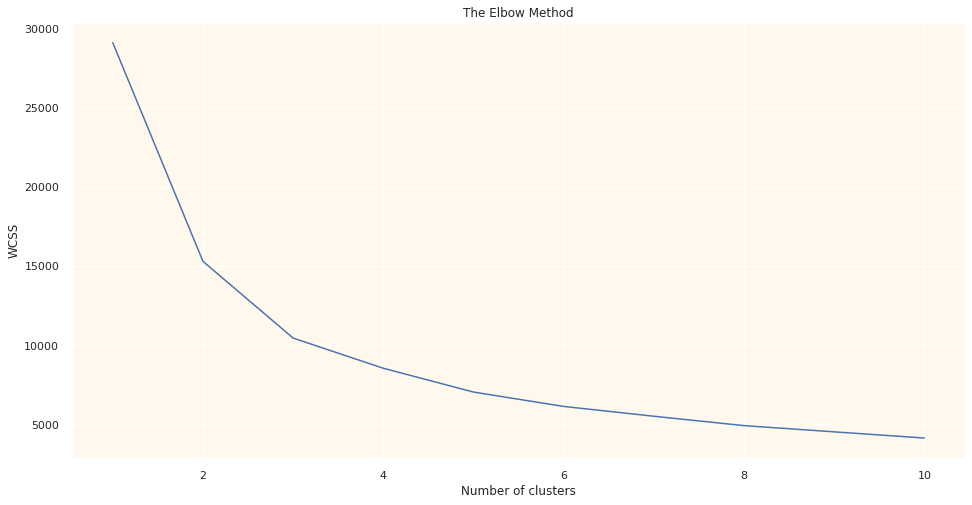

In [114]:
wcss=[]
for i in range (1,11):
 kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
 kmeans.fit(PCA_ds)
 wcss.append(kmeans.inertia_)
plt.figure(figsize=(16,8))
plt.plot(range(1,11),wcss, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

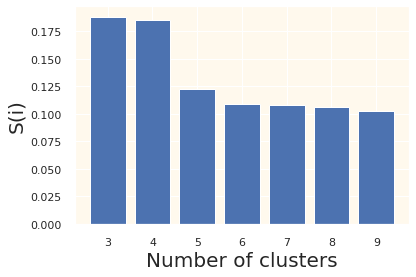

In [115]:

from sklearn.metrics import silhouette_score 
silhouette_scores = []
for i in range(3,10):
    m1=KMeans(n_clusters=i, random_state=42)
    c = m1.fit_predict(PCA_ds)
    silhouette_scores.append(silhouette_score(scaled_ds, m1.fit_predict(PCA_ds))) 
plt.bar(range(3,10), silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()


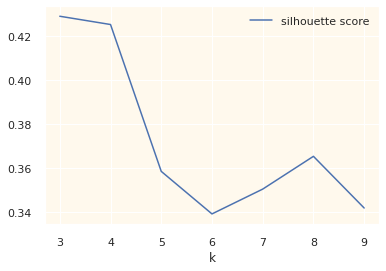

In [116]:
X = scaled_ds.values
from sklearn.metrics import silhouette_score
k_values= []
silhouette_score_values = []

for i in range(3,10):
  kmeans = KMeans(n_clusters = i)
  y_pred = kmeans.fit_predict(PCA_ds)
  k_values.append(i)
  silhouette_score_values.append(silhouette_score(PCA_ds,y_pred))

result = pd.DataFrame({'k': k_values, 'silhouette score': silhouette_score_values})
result.plot.line(x='k', y='silhouette score')
plt.show()

In [119]:
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=4)
y_pred = kmeans.fit_predict(PCA_ds)
PCA_ds["Clusters"] = y_pred
print(silhouette_score(PCA_ds,y_pred))

0.4666491739559254


In [120]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,FrozenCommodity,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,TotalPurchases
0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57283200000000000,64,1617,0,0,1,0,25
1,0,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,9763200000000000,67,27,0,2,3,1,6
2,0,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,26956800000000000,56,776,1,0,2,0,21
3,0,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,12009600000000000,37,53,1,1,3,1,8
4,1,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,13910400000000000,40,422,1,1,3,1,19


In [121]:

data["Clusters"]=y_pred

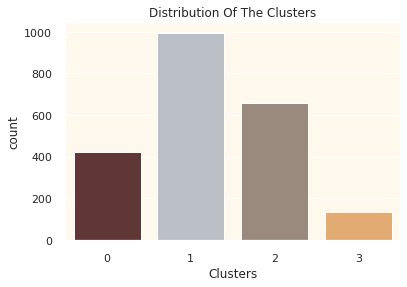

In [122]:
#Plotting countplot of clusters
data["Clusters"]=y_pred
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

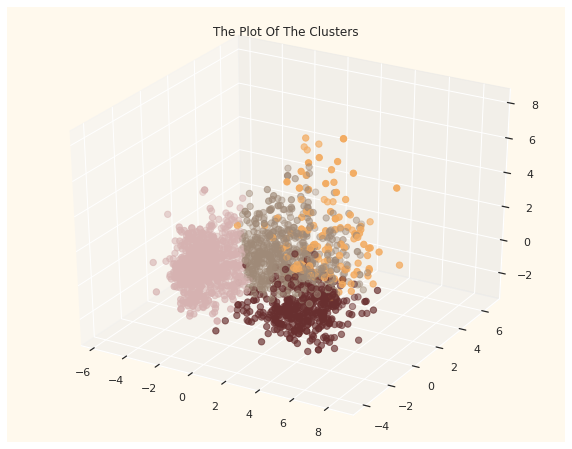

In [123]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

In [124]:
data_Pie = pd.DataFrame(data['Clusters'].value_counts()).reset_index()
data_Pie.columns = ['Clusters', 'Count']

fig = go.Figure(data=[go.Pie(labels=data_Pie['Clusters'], values=data_Pie['Count'], hole=.3)])
fig.update_layout(width=800, height=400, title='Clusters')
fig.show()

In [125]:
fig = px.scatter(data, x="Income", y="Spent",
                 color="Clusters",
                 hover_data=['Spent', 'Income', 'Clusters'])

fig.update_layout(
    title="Spend vs Income Plot",
    xaxis_title = "Spend",
    yaxis_title = "Income",
    width = 900, height=600
)

fig.show()

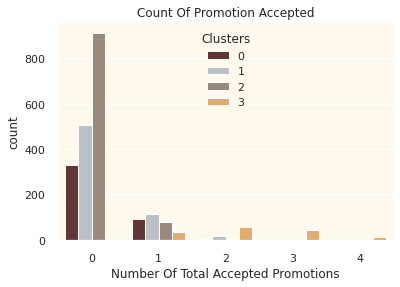

In [ ]:
# Tạo tính năng để nhận tổng số khuyến mại được chấp nhận
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
# Plotting tổng số chiến dịch được chấp nhận.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

In [ ]:
data["Total_Promos"]

0       0
1       0
2       0
3       0
4       0
       ..
2235    0
2236    1
2237    1
2238    0
2239    0
Name: Total_Promos, Length: 2207, dtype: int64

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling

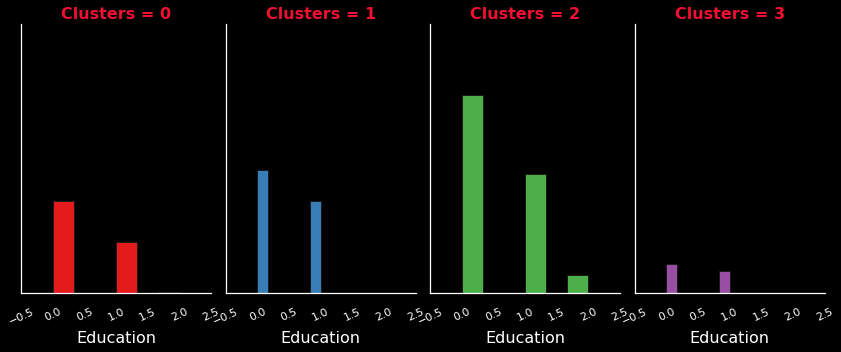

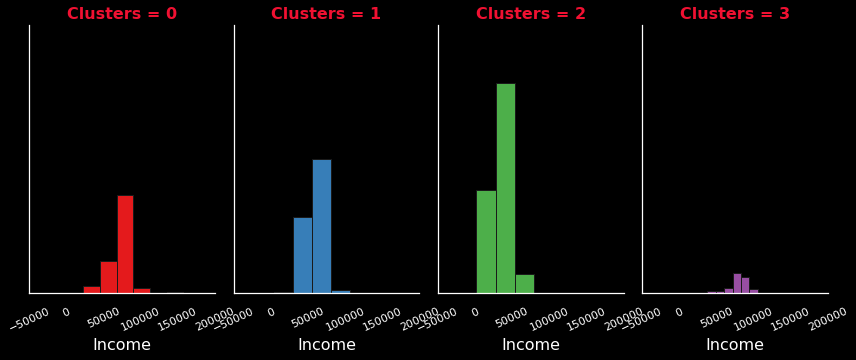

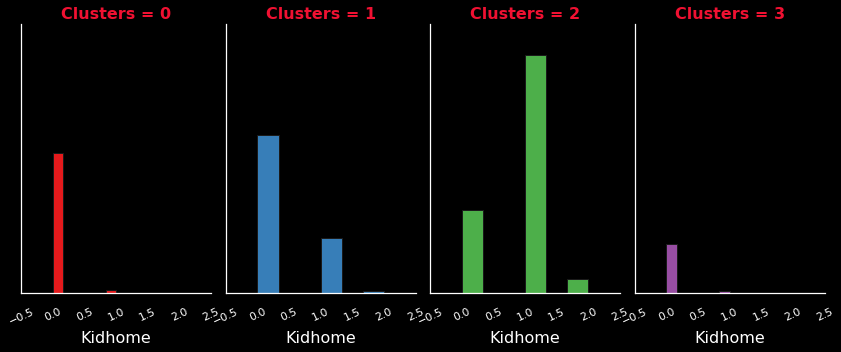

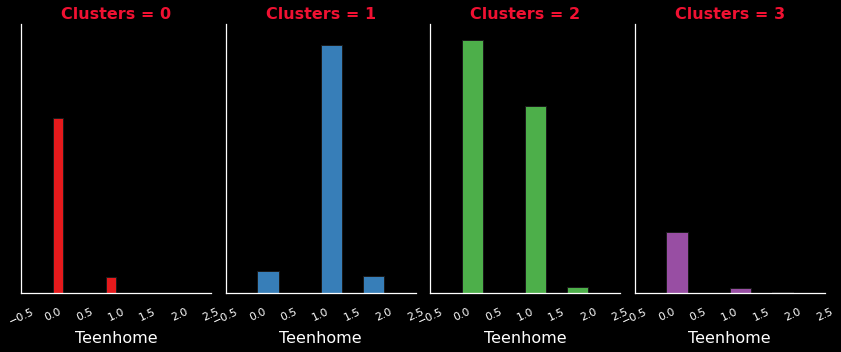

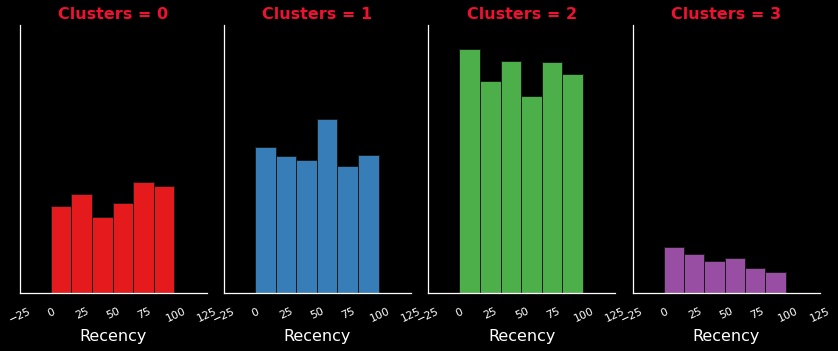

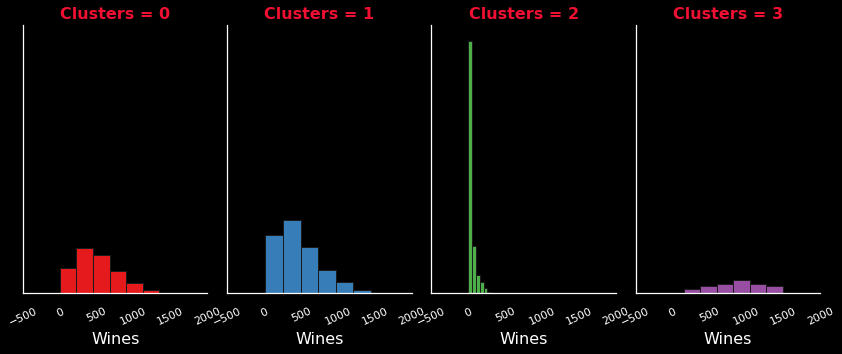

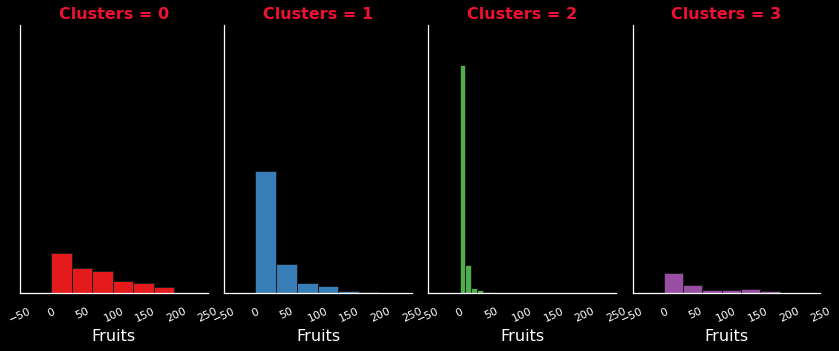

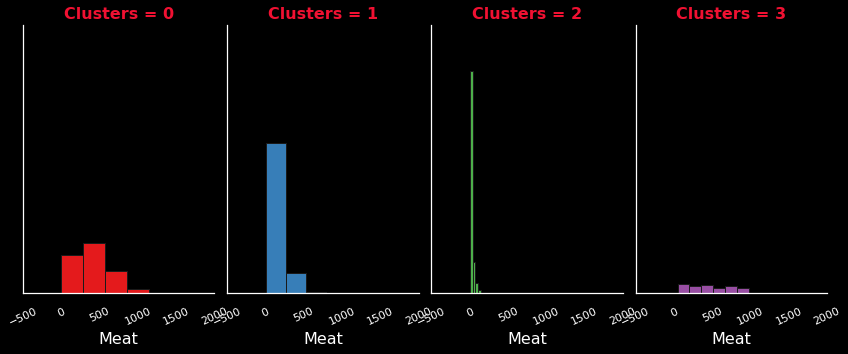

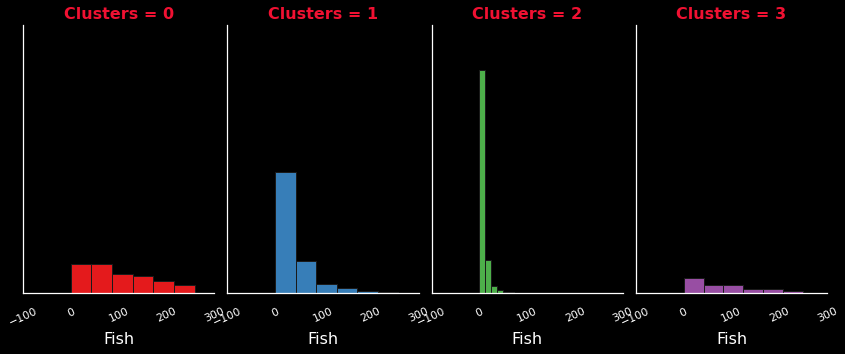

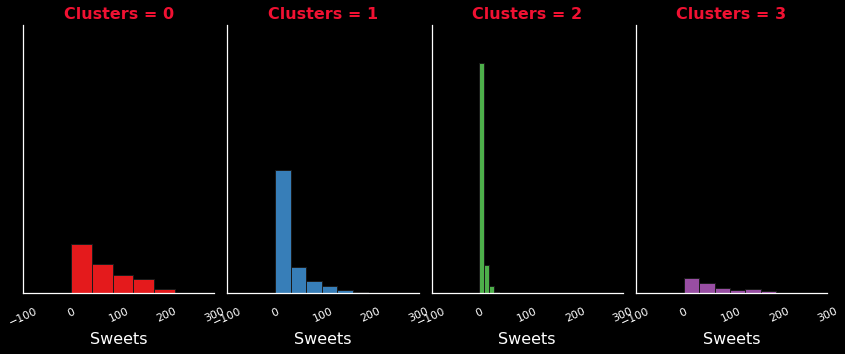

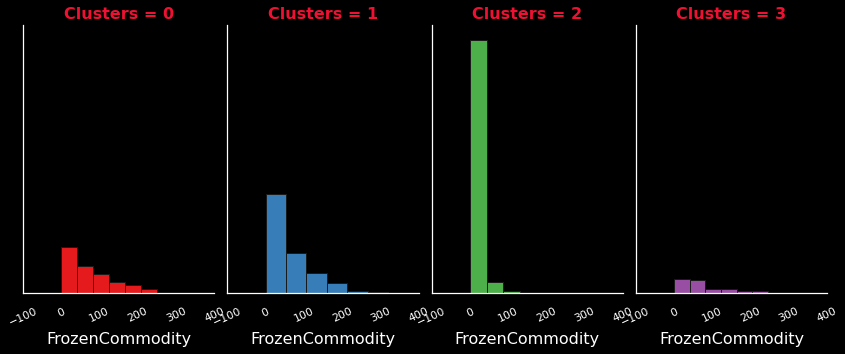

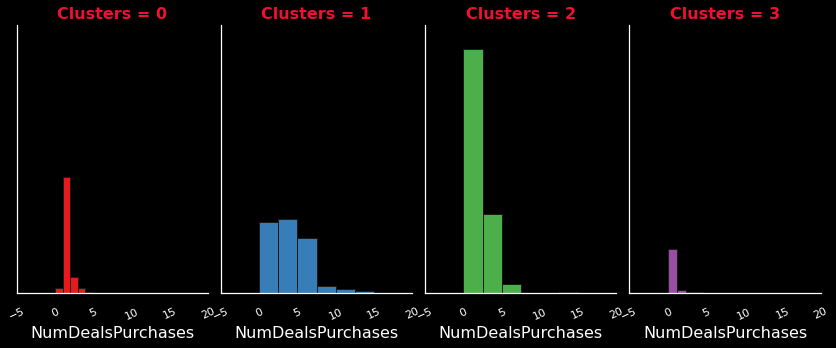

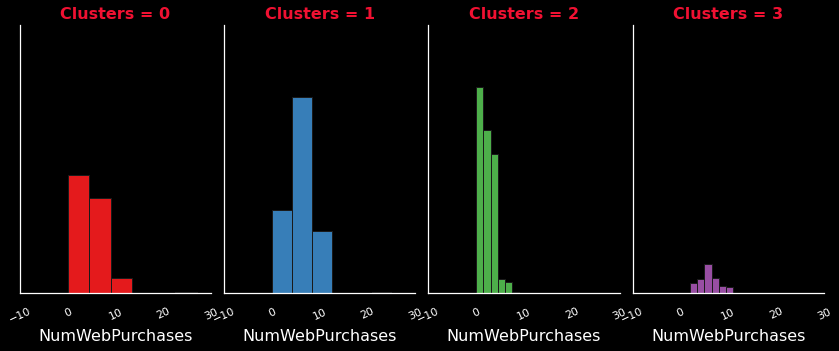

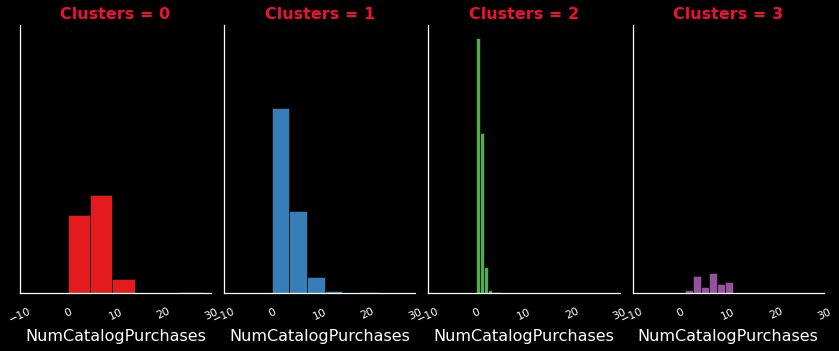

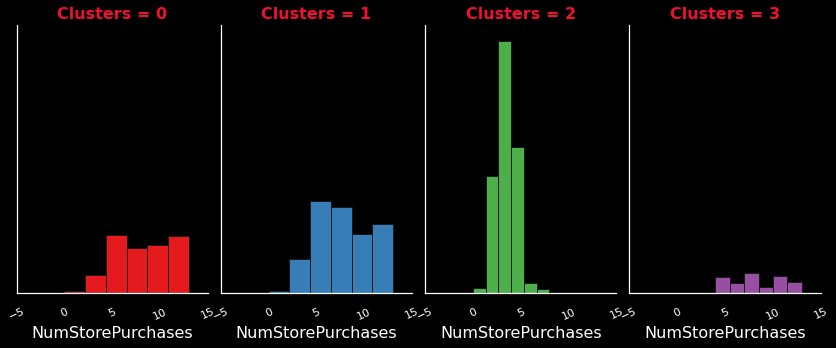

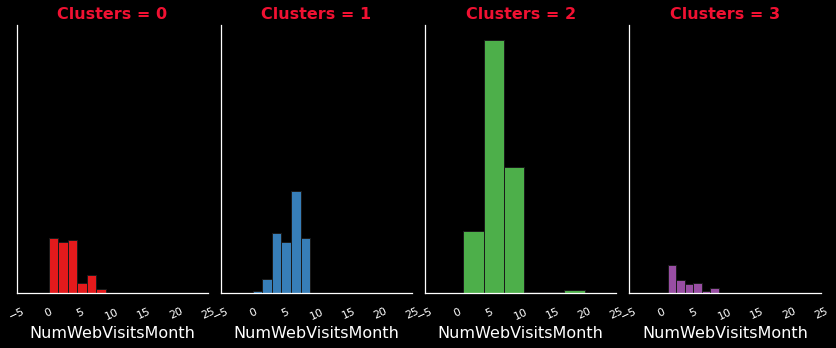

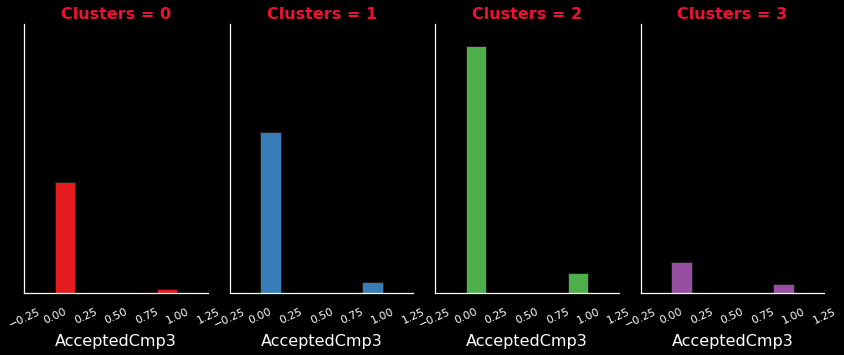

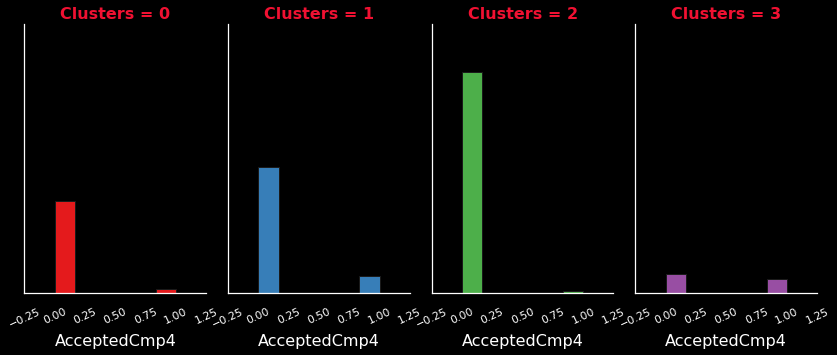

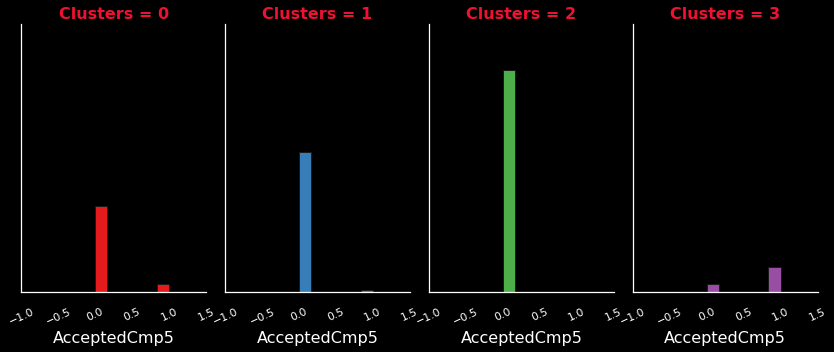

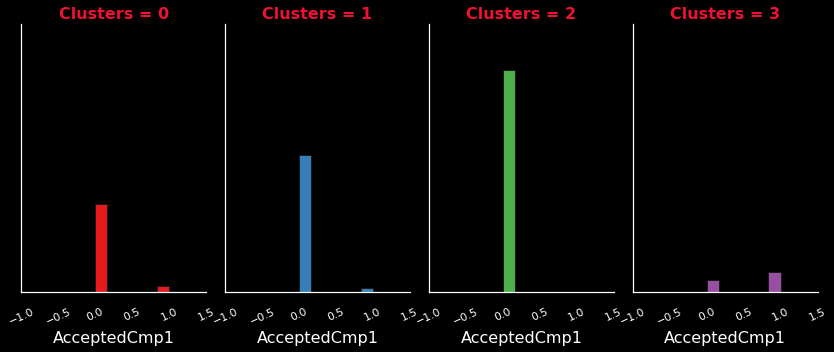

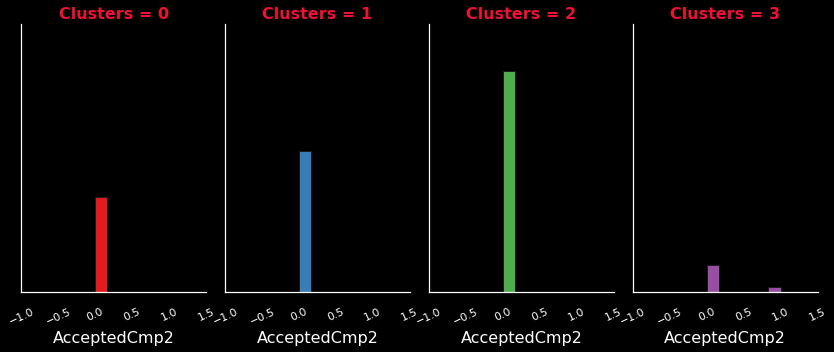

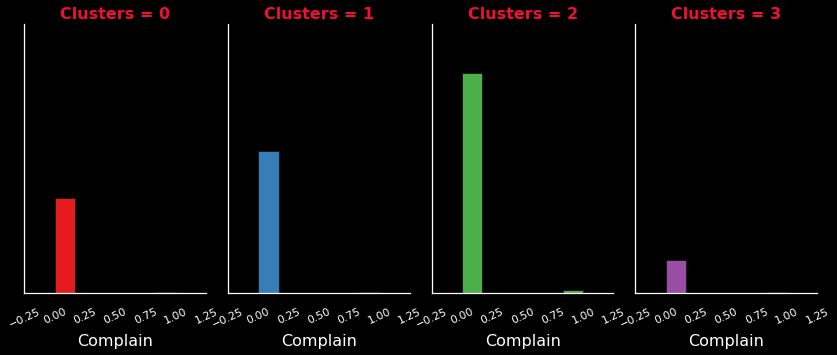

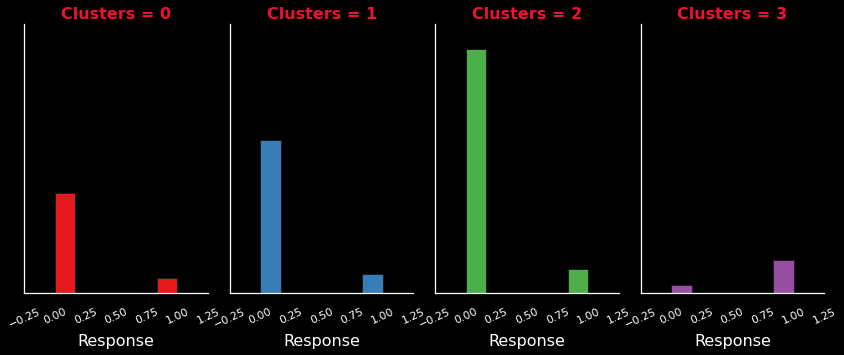

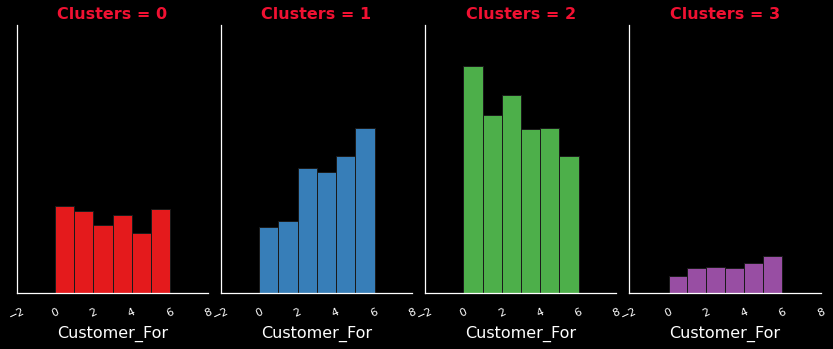

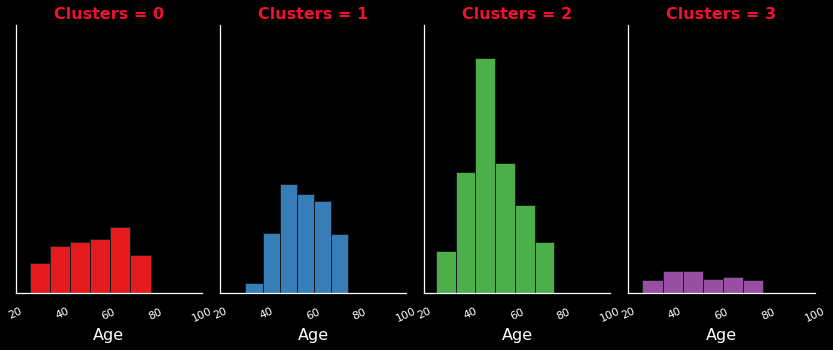

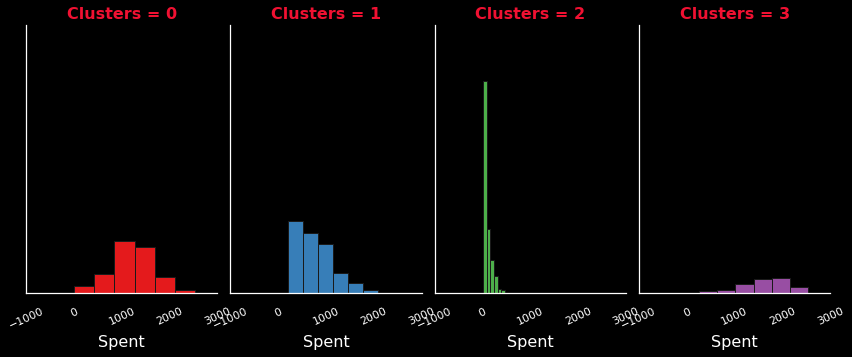

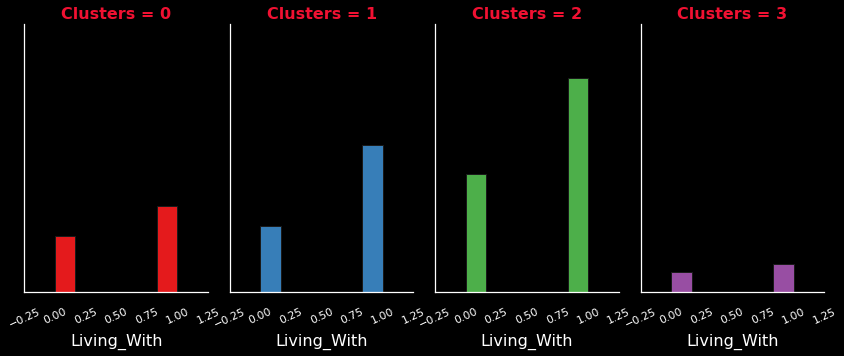

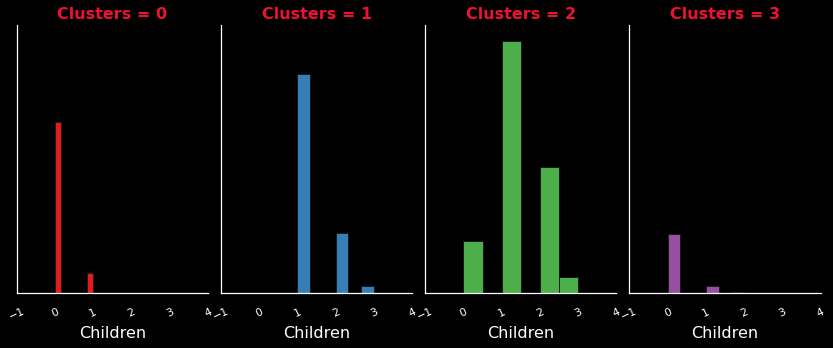

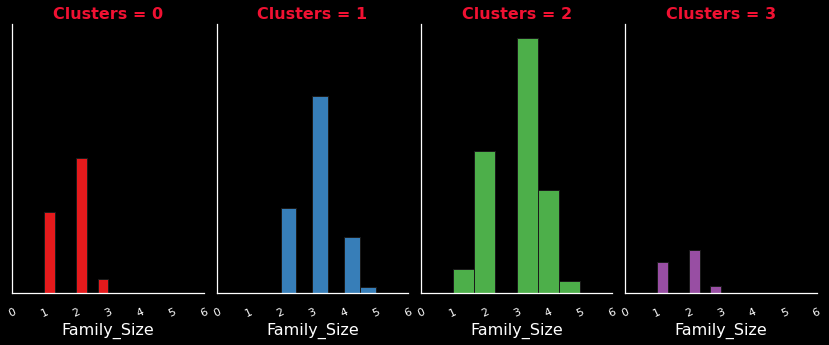

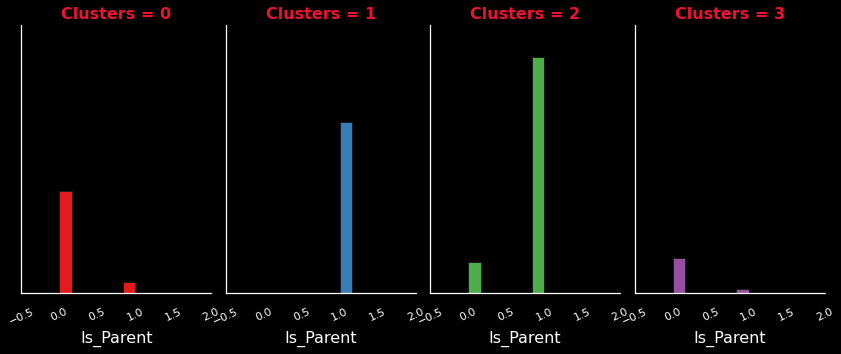

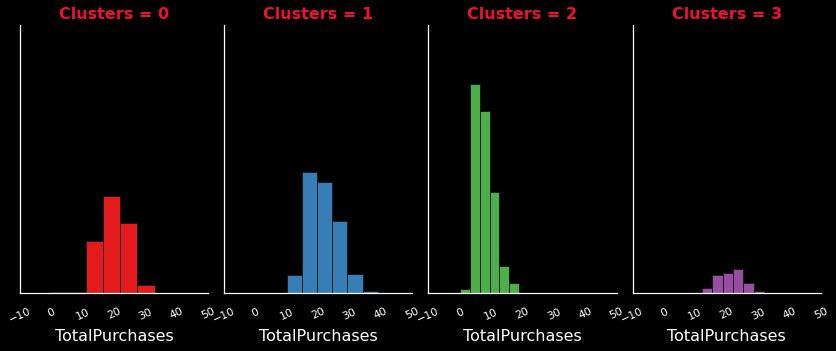

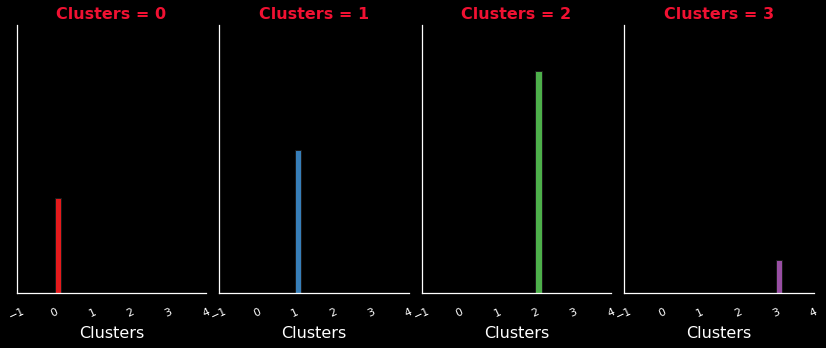

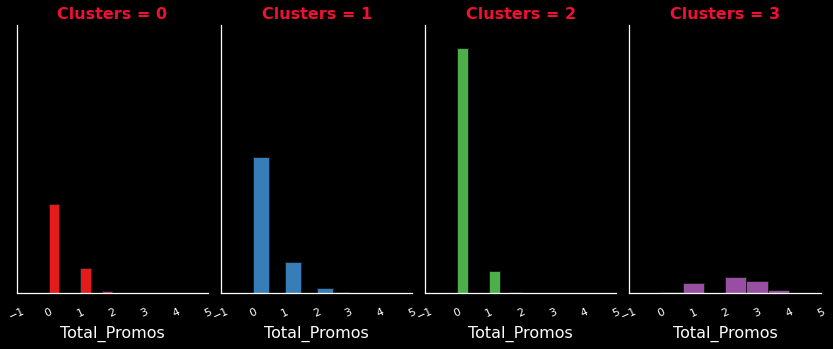

In [ ]:
# Clusters interpretation 
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'font.family': 'Ubuntu'})

for i in data:
    diag = sns.FacetGrid(data, col = "Clusters", hue = "Clusters", palette = "Set1")
    diag.map(plt.hist, i, bins=6, ec="k") 
    diag.set_xticklabels(rotation=25, color = 'white')
    diag.set_yticklabels(color = 'white')
    diag.set_xlabels(size=16, color = 'white')
    diag.set_titles(size=16, color = '#f01132', fontweight="bold")
    diag.fig.set_figheight(6)

In [ ]:
fig = px.scatter(data, x="Family_Size", y="Age",
                 color="Clusters",
                 hover_data=['Family_Size', 'Age', 'Clusters'])

fig.update_layout(
    title="Family_Size vs Age Plot",
    xaxis_title = "Family_Size",
    yaxis_title = "Age",
    width = 900, height=600
)

fig.show()

In [ ]:
fig =  px.pie (data, names = "Living_With", hole = 0.4, template = "gridon")
fig.show ()

In [ ]:
fig =  px.pie (data, names = "Education", hole = 0.4, template = "plotly_dark")
fig.show ()